 # 1. Importing Relevant Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import seaborn as sns

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 2. Importing MovieLens Dataset

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#20m_750users_750movies
#https://drive.google.com/file/d/1ojdy3h32jevDcsLurXMvrZ4Zy5I4M_z2/view?usp=sharing (User-ratings-dataset)
User_ratings_file_id = '1ojdy3h32jevDcsLurXMvrZ4Zy5I4M_z2' 
User_ratings_downloaded = drive.CreateFile({'id': User_ratings_file_id})
print('Downloaded content "{}"'.format(User_ratings_downloaded.GetContentString()))

Downloaded content "﻿userId,movieId,rating,timestamp
1,2,3.5,1112486027
1,29,3.5,1112484676
1,32,3.5,1112484819
1,47,3.5,1112484727
1,50,3.5,1112484580
1,112,3.5,1094785740
1,151,4,1094785734
1,223,4,1112485573
1,253,4,1112484940
1,260,4,1112484826
1,293,4,1112484703
1,296,4,1112484767
1,318,4,1112484798
1,337,3.5,1094785709
1,367,3.5,1112485980
1,541,4,1112484603
1,589,3.5,1112485557
1,593,3.5,1112484661
1,653,3,1094785691
2,3,4,974820889
2,62,5,974820598
2,70,5,974820691
2,110,4,974820658
2,242,3,974820776
2,260,5,974821014
2,266,5,974820748
2,469,3,974820598
2,480,5,974820720
2,541,5,974821014
2,589,5,974820658
3,1,4,944919407
3,24,3,945176048
3,32,4,944918047
3,50,5,944918018
3,160,3,945176048
3,173,2,945176099
3,175,5,944919133
3,196,3,945175939
3,223,5,944918444
3,260,5,944917742
3,316,5,945175870
3,318,5,944917766
3,329,5,945176021
3,337,3,944919366
3,440,3,944918500
3,442,3,945176005
3,457,5,944918215
3,480,5,945175820
3,490,5,944919041
3,512,2,945176005
3,541,5,944918047
3,589

In [ ]:
User_ratings_downloaded.GetContentFile('20m_750users_750movies.csv')

In [ ]:
#https://drive.google.com/file/d/1iXyiV89uAJUYTPG99MNh-5RtYhPeNzR4/view?usp=sharing (movie-dataset)
movies_file_id = '1iXyiV89uAJUYTPG99MNh-5RtYhPeNzR4' 
movies_downloaded = drive.CreateFile({'id': movies_file_id})
print('Downloaded content "{}"'.format(movies_downloaded.GetContentString()))

Downloaded content "movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
7,Sabrina (1995),Comedy|Romance
8,Tom and Huck (1995),Adventure|Children
9,Sudden Death (1995),Action
10,GoldenEye (1995),Action|Adventure|Thriller
11,"American President, The (1995)",Comedy|Drama|Romance
12,Dracula: Dead and Loving It (1995),Comedy|Horror
13,Balto (1995),Adventure|Animation|Children
14,Nixon (1995),Drama
15,Cutthroat Island (1995),Action|Adventure|Romance
16,Casino (1995),Crime|Drama
17,Sense and Sensibility (1995),Drama|Romance
18,Four Rooms (1995),Comedy
19,Ace Ventura: When Nature Calls (1995),Comedy
20,Money Train (1995),Action|Comedy|Crime|Drama|Thriller
21,Get Shorty (1995),Comedy|Crime|Thriller
22,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller
23

In [ ]:
movies_downloaded.GetContentFile('movies.csv')

In [ ]:
#First 750 users and first 750 movies from the original dataset.
#Dataset file too large to import the whole thing.
#Ensure the target attribute is at the last column. If not, make it the last column.
#user_ratings_df = pd.read_csv("20m_5000users_7000movies.csv")
#user_ratings_df = pd.read_csv("20m-5000users-2000movies.csv")
user_ratings_df = pd.read_csv("20m_750users_750movies.csv")

user_ratings_df = user_ratings_df.drop(['timestamp'], 1) 
user_ratings_df

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
25498,750,719,3.0
25499,750,725,3.0
25500,750,733,3.0
25501,750,736,3.0


In [ ]:
movies_df = pd.read_csv("movies.csv")
movies_df = movies_df.drop(['genres'], 1) #Remove redundant attribute
movies_df

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
27273,131254,Kein Bund für's Leben (2007)
27274,131256,"Feuer, Eis & Dosenbier (2002)"
27275,131258,The Pirates (2014)
27276,131260,Rentun Ruusu (2001)


In [ ]:
#Check for duplicates

has_duplicate = user_ratings_df.duplicated()
duplicates = user_ratings_df[has_duplicate]
print(duplicates)

has_duplicate = user_ratings_df.duplicated()
duplicates = user_ratings_df[has_duplicate]
print(duplicates)

Empty DataFrame
Columns: [userId, movieId, rating]
Index: []
Empty DataFrame
Columns: [userId, movieId, rating]
Index: []


# 3. Train-Test-Data Split

In [ ]:
train_df, test_df = train_test_split(user_ratings_df, test_size=0.2)
train_df = train_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [ ]:
train_df

,userId,movieId,rating
0,190,720,3.0
1,330,371,3.0
2,16,6,3.0
3,309,596,3.0
4,414,595,5.0
...,...,...,...
20397,294,590,2.0
20398,1,50,3.5
20399,298,174,3.0
20400,500,616,4.0


In [ ]:
test_df

,userId,movieId,rating
0,517,454,4.0
1,421,185,2.5
2,486,708,4.0
3,677,380,4.0
4,448,441,4.0
...,...,...,...
5096,14,586,2.5
5097,142,316,4.0
5098,514,529,4.0
5099,473,707,4.0


# 4. Item-item CF Algorithm

In [ ]:
train_df_matrix = train_df.pivot(index='movieId',columns='userId',values='rating').fillna(0)
train_df_matrix

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,39,40,41,...,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,4.5,4.0,4.0,4.5,0.0,3.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,...,5.0,3.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,5.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,5.0,0.0,3.5,5.0,0.0,3.5,0.0,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,2.5,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
3,0.0,0.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


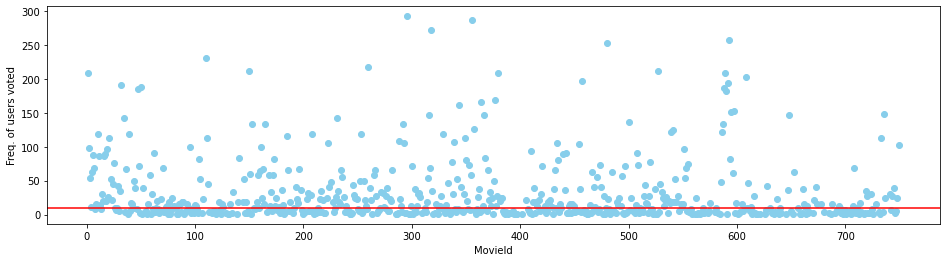

In [ ]:
#Mitigate 'cold-start' problem
#Only allow movies which has been voted more than 15 times
#Only allow users who votes more than 20 times

freq_user_voted = train_df.groupby('movieId')['rating'].agg('count')
freq_movies_voted = train_df.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(freq_user_voted.index,freq_user_voted,color='skyblue')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('Freq. of users voted')
plt.show()

In [ ]:
train_df_matrix = train_df_matrix.loc[freq_user_voted[freq_user_voted >= 10].index,:]
test_df = test_df.loc[test_df['movieId'].isin(freq_user_voted[freq_user_voted >= 10].index.to_list())]

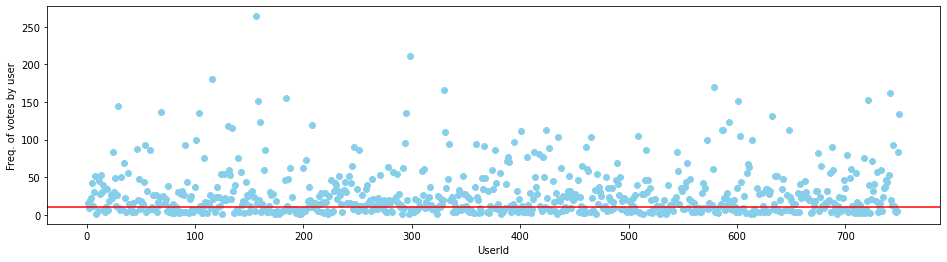

In [ ]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(freq_movies_voted.index,freq_movies_voted,color='skyblue')
plt.axhline(y=10,color='r')
plt.xlabel('UserId')
plt.ylabel('Freq. of votes by user')
plt.show()

In [ ]:
train_df_matrix = train_df_matrix.loc[:,freq_movies_voted[freq_movies_voted >= 10].index]
test_df = test_df.loc[test_df['userId'].isin(freq_movies_voted[freq_movies_voted >= 10].index.to_list())]

In [ ]:
test_df

,userId,movieId,rating
0,517,454,4.0
1,421,185,2.5
2,486,708,4.0
3,677,380,4.0
4,448,441,4.0
...,...,...,...
5096,14,586,2.5
5097,142,316,4.0
5098,514,529,4.0
5099,473,707,4.0


In [ ]:
train_df_matrix

userId,1,3,4,5,6,7,8,11,12,13,14,15,18,19,21,22,23,24,25,26,27,28,29,32,34,35,38,39,40,43,46,47,48,50,51,52,53,54,56,58,...,690,693,694,698,699,700,702,704,705,706,708,710,711,714,717,720,721,722,724,725,726,727,728,729,731,732,733,735,736,737,738,739,740,741,742,743,744,745,749,750
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,4.0,0.0,0.0,5.0,0.0,4.0,4.5,4.0,4.0,4.5,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,5.0,...,0.0,0.0,4.5,0.0,4.0,4.0,3.5,0.0,0.0,0.0,3.0,4.0,5.0,4.0,0.0,0.0,0.0,0.0,4.5,5.0,0.0,0.0,5.0,3.0,0.0,0.0,5.0,3.5,5.0,0.0,3.5,0.0,0.0,5.0,5.0,0.0,4.0,0.0,4.0,0.0
2,3.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,2.5,0.0,3.0,0.0,3.0,0.0,0.0,3.0,3.0
3,0.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.5,0.0,0.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,2.5,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
743,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df_matrix_csr = csr_matrix(train_df_matrix.values)
train_df_matrix.reset_index(inplace=True)

In [ ]:
#knn
#cosine-similarity
#train knn with training data

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=30, n_jobs=-1)
knn.fit(train_df_matrix_csr)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
                 radius=1.0)

In [ ]:
def get_movie_recommendation(movie_id, n_movies_to_recomend):
    movie_idx = train_df_matrix[train_df_matrix['movieId'] == movie_id].index[0]

    distances , indices = knn.kneighbors(train_df_matrix_csr[movie_idx],n_neighbors=n_movies_to_recomend+1)    
    rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                        key=lambda x: x[1])[:0:-1]
        
    recommend_frame = []
        
    for val in rec_movie_indices:
        movie_idx = train_df_matrix.iloc[val[0]]['movieId']
        idx = movies_df[movies_df['movieId'] == movie_idx].index
        recommend_frame.append({'Title':movies_df.iloc[idx]['title'].values[0],'Distance':val[1]})
    df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_recomend+1))
    return df

In [ ]:
movies_df

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
27273,131254,Kein Bund für's Leben (2007)
27274,131256,"Feuer, Eis & Dosenbier (2002)"
27275,131258,The Pirates (2014)
27276,131260,Rentun Ruusu (2001)


In [ ]:
get_movie_recommendation(1, 10)

,Title,Distance
1,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),0.573775
2,Jurassic Park (1993),0.572628
3,"Shawshank Redemption, The (1994)",0.571458
4,Mission: Impossible (1996),0.561050
5,True Lies (1994),0.559664
6,"Lion King, The (1994)",0.555358
7,Star Wars: Episode IV - A New Hope (1977),0.551893
8,Aladdin (1992),0.550782
9,Forrest Gump (1994),0.548737
10,Twister (1996),0.537998


In [ ]:
#weighted average

def predict_ratings(userid, movieid, n_movie_recommend):
    total = 0
    total_weight = 0
    df = get_movie_recommendation(movieid, n_movie_recommend)
    for i in range(len(df)):
        movie_title = df.iloc[i]['Title']
        movie_id = movies_df.loc[movies_df['title'] == movie_title].iloc[0]['movieId']
        cos_sim = df.iloc[i]['Distance']
        match_df = train_df.loc[train_df['userId'] == userid]
        match_df = match_df.loc[match_df['movieId'] == movie_id]
        if (match_df.empty):
            continue
        else:
            movie_rating = match_df.iloc[0]['rating']
            total = total + (cos_sim * movie_rating)
            total_weight = total_weight + cos_sim
    
    if (total_weight == 0):
        pred_rate = 0
    else:
        #pred_rate = (total / df['Distance'].sum())
        pred_rate = (total / total_weight)
    return round(pred_rate, 2)


# 5. Test

In [ ]:
#Test algorithm on random sample from test data

attributes_df = list(user_ratings_df.columns)
attributes_df.remove('rating')

test_x = test_df[attributes_df]
test_y = test_df['rating']

n_movies_to_recommend = 10
random_sample = random.randrange(len(test_x))
predicted_rating = predict_ratings(test_x.iloc[random_sample]['userId'], test_x.iloc[random_sample]['movieId'], n_movies_to_recommend)
print(test_x.iloc[random_sample])
print(f"Predicted rating: {predicted_rating}")
print(f"Truth: {test_y.values[random_sample]}")

userId     34
movieId    60
Name: 1956, dtype: int64
Predicted rating: 3.51
Truth: 4.0


# 6. Evaluate

In [ ]:
#test_df.loc[test_df['movieId'] == 1412]

In [ ]:
#RMSE
"""
def compute_rmse():
    test_y_array = test_df['rating'].to_list()
    predicted_array = []
    for i in range(len(test_df)):
    #for i in range(len(test_x)):
        predicted_array.append(predict_ratings(test_x.iloc[i]['userId'], test_x.iloc[i]['movieId']))
    predicted_array = np.asarray(predicted_array)
    #print(test_y_array[:27])
    #print(predicted_array)
    print(mean_squared_error(test_y_array, predicted_array, squared=False))

compute_rmse()
"""

"\ndef compute_rmse():\n    test_y_array = test_df['rating'].to_list()\n    predicted_array = []\n    for i in range(len(test_df)):\n    #for i in range(len(test_x)):\n        predicted_array.append(predict_ratings(test_x.iloc[i]['userId'], test_x.iloc[i]['movieId']))\n    predicted_array = np.asarray(predicted_array)\n    #print(test_y_array[:27])\n    #print(predicted_array)\n    print(mean_squared_error(test_y_array, predicted_array, squared=False))\n\ncompute_rmse()\n"

In [ ]:
# Add new column, likes
# ratings >= 3 -> 1
# ratings <3 -> 0
# 1 means user likes purchased movie
# 0 means user dislikes purchased movie


likes = (test_df['rating'] >= 3).to_list()
test_df['likes'] = likes
test_df['likes'] = test_df['likes'].astype(int)
test_df

,userId,movieId,rating,likes
0,517,454,4.0,1
1,421,185,2.5,0
2,486,708,4.0,1
3,677,380,4.0,1
4,448,441,4.0,1
...,...,...,...,...
5096,14,586,2.5,0
5097,142,316,4.0,1
5098,514,529,4.0,1
5099,473,707,4.0,1


In [ ]:
#RSMD
#Recall
#Code roughly takes 50 mins to run
#Run code below for a faster evaluation

n_movies_to_recommend = 100

def compute_performance():
    test_y_array = test_df['rating'].to_list()
    predicted_array = []
    for i in range(len(test_df)):
    #for i in range(100):
        predicted_array.append(predict_ratings(test_x.iloc[i]['userId'], test_x.iloc[i]['movieId'],n_movies_to_recommend))
    predicted_array = np.asarray(predicted_array)
    rsmd = mean_squared_error(test_y_array, predicted_array, squared=False)
    #print(f"Truth Ratings:     {test_y_array}")
    #rsmd = mean_squared_error(test_y_array[:100], predicted_array, squared=False)
    #print(f"Truth Ratings:     {test_y_array[:100]}")
    #print(f"Predicted Ratings: {predicted_array}")
    print(f"RSMD: {rsmd}\n")

    for index, item in enumerate(predicted_array):
      if item >= 3:
        predicted_array[index] = 1
      else:
        predicted_array[index] = 0
  
    test_y2_array = test_df['likes'].to_list()
    #print(f"Truth:     {test_y2_array}")
    #print(f"Truth:     {test_y2_array[:100]}")
    #print(f"Predicted: {predicted_array}")

    #recall1 = recall_score(test_y2_array, predicted_array, average='macro')
    #recall2 = recall_score(test_y2_array, predicted_array, average='micro')
    recall3 = recall_score(test_y2_array, predicted_array, average='weighted')
    #recall1 = recall_score(test_y2_array[:100], predicted_array, average='macro')
    #recall2 = recall_score(test_y2_array[:100], predicted_array, average='micro')
    #recall3 = recall_score(test_y2_array[:100], predicted_array, average='weighted')   
    #print(f"Recall Score (Macro): {recall1}")
    #print(f"Recall Score (Micro): {recall2}")
    print(f"Recall Score (Weighted): {recall3}\n")

compute_performance()

KeyboardInterrupt: ignored

In [ ]:
#Faster performance evaluation.
#Only uses first 100 user-movie pair.
#Does not iterate through the whole test data.
#Takes roughly 1 min to run
#More or less the same performance

n_movies_to_recommend = 100

def compute_performance():
    test_y_array = test_df['rating'].to_list()
    predicted_array = []
    for i in range(100):
        predicted_array.append(predict_ratings(test_x.iloc[i]['userId'], test_x.iloc[i]['movieId'],n_movies_to_recommend))
    predicted_array = np.asarray(predicted_array)
    rsmd = mean_squared_error(test_y_array[:100], predicted_array, squared=False)
    #print(f"Truth Ratings:     {test_y_array[:100]}")
    #print(f"Predicted Ratings: {predicted_array}")
    print(f"RSMD: {rsmd}\n")

    for index, item in enumerate(predicted_array):
      if item >= 3:
        predicted_array[index] = 1
      else:
        predicted_array[index] = 0
  
    test_y2_array = test_df['likes'].to_list()
    #print(f"Truth:     {test_y2_array[:100]}")
    #print(f"Predicted: {predicted_array}")

    recall1 = recall_score(test_y2_array[:100], predicted_array, average='macro')
    recall2 = recall_score(test_y2_array[:100], predicted_array, average='micro')
    recall3 = recall_score(test_y2_array[:100], predicted_array, average='weighted')   
    print(f"Recall Score (Macro): {recall1}")
    print(f"Recall Score (Micro): {recall2}")
    print(f"Recall Score (Weighted): {recall3}\n")

compute_performance()

In [ ]:
#Faster performance evaluation.
#Only uses first 10 user-movie pair.
#Does not iterate through the whole test data.

n_movies_to_recommend = 100

def compute_performance():
    test_y_array = test_df['rating'].to_list()
    predicted_array = []
    for i in range(10):
        predicted_array.append(predict_ratings(test_x.iloc[i]['userId'], test_x.iloc[i]['movieId'],n_movies_to_recommend))
    predicted_array = np.asarray(predicted_array)
    rsmd = mean_squared_error(test_y_array[:10], predicted_array, squared=False)
    #print(f"Truth Ratings:     {test_y_array[:10]}")
    #print(f"Predicted Ratings: {predicted_array}")
    print(f"RSMD: {rsmd}\n")

    for index, item in enumerate(predicted_array):
      if item >= 3:
        predicted_array[index] = 1
      else:
        predicted_array[index] = 0
  
    test_y2_array = test_df['likes'].to_list()
    #print(f"Truth:     {test_y2_array[:10]}")
    #print(f"Predicted: {predicted_array}")

    recall1 = recall_score(test_y2_array[:10], predicted_array, average='macro')
    recall2 = recall_score(test_y2_array[:10], predicted_array, average='micro')
    recall3 = recall_score(test_y2_array[:10], predicted_array, average='weighted')   
    print(f"Recall Score (Macro): {recall1}")
    print(f"Recall Score (Micro): {recall2}")
    print(f"Recall Score (Weighted): {recall3}\n")

compute_performance()

RSMD: 0.5246141439191284

Recall Score (Macro): 0.4375
Recall Score (Micro): 0.7
Recall Score (Weighted): 0.7



In [ ]:
"""
    predicted_array = [round(num) for num in predicted_array]
    test_y_array = [round(num) for num in test_y_array]
    print(test_y_array[:10])
    print(predicted_array)
    recall1 = recall_score(test_y_array[:10], predicted_array, average='macro')
    recall2 = recall_score(test_y_array[:10], predicted_array, average='micro')
    recall3 = recall_score(test_y_array[:10], predicted_array, average='weighted')   
    print(f"Recall Score (Macro): {recall1}")
    print(f"Recall Score (Micro): {recall2}")
    print(f"Recall Score (Weighted): {recall3}\n")

    precision_score1 = precision_score(test_y_array[:10], predicted_array, average='macro')
    precision_score2 = precision_score(test_y_array[:10], predicted_array, average='micro')
    precision_score3 = precision_score(test_y_array[:10], predicted_array, average='weighted')   
    print(f"precision Score (Macro): {precision_score1}")
    print(f"Precision Score (Micro): {precision_score2}")
    print(f"Precision Score (Weighted): {precision_score3}\n")

    f1_score1 = f1_score(test_y_array[:10], predicted_array, average='macro')
    f1_score2 = f1_score(test_y_array[:10], predicted_array, average='micro')
    f1_score3 = f1_score(test_y_array[:10], predicted_array, average='weighted')   
    print(f"F1 Score (Macro): {f1_score1}")
    print(f"F1 Score (Micro): {f1_score2}")
    print(f"F1 Score (Weighted): {f1_score3}\n")
"""

'\n    predicted_array = [round(num) for num in predicted_array]\n    test_y_array = [round(num) for num in test_y_array]\n    print(test_y_array[:10])\n    print(predicted_array)\n    recall1 = recall_score(test_y_array[:10], predicted_array, average=\'macro\')\n    recall2 = recall_score(test_y_array[:10], predicted_array, average=\'micro\')\n    recall3 = recall_score(test_y_array[:10], predicted_array, average=\'weighted\')   \n    print(f"Recall Score (Macro): {recall1}")\n    print(f"Recall Score (Micro): {recall2}")\n    print(f"Recall Score (Weighted): {recall3}\n")\n\n    precision_score1 = precision_score(test_y_array[:10], predicted_array, average=\'macro\')\n    precision_score2 = precision_score(test_y_array[:10], predicted_array, average=\'micro\')\n    precision_score3 = precision_score(test_y_array[:10], predicted_array, average=\'weighted\')   \n    print(f"precision Score (Macro): {precision_score1}")\n    print(f"Precision Score (Micro): {precision_score2}")\n    pri